## Representation of performance with each parameter

In [1]:
import pandas as pd
import json
import glob
import re
import numpy as np
import seaborn as sns

In [13]:
outputs = []
for file in glob.glob("./output/*.json"):
    output = pd.DataFrame(json.load(open(file, "r")))
    output["settings"] = file
    outputs.append(output)
result = pd.concat(outputs)

In [14]:
toplots = []
for subset in outputs:
    toplot = subset.loc[:,['test_settings','eval_score_gemini-2.0-flash']]
    values = [toplot.test_settings[0].split('_')[i] for i in [1,3,6,7,9]]
    toplot2 = {"Chunk_size": np.repeat(values[0], toplot.shape[0]),
    "LLM_model":np.repeat(values[1], toplot.shape[0]),
    "Embedding_Model":np.repeat(re.sub(r'recursive','',values[2]),toplot.shape[0]),
    "Recursive":np.repeat(values[3], toplot.shape[0]),
    "NumberofDocuments":np.repeat(values[4], toplot.shape[0])}
    toplots.append(pd.concat([pd.DataFrame(toplot2), toplot['eval_score_gemini-2.0-flash']], axis=1))
toplot_final = pd.concat(toplots)

### LinePlot

In [15]:
toplot_final["eval_score_gemini-2.0-flash"] = toplot_final["eval_score_gemini-2.0-flash"].apply(lambda x: int(x) if isinstance(x, str) else 0)
toplot_final["eval_score_gemini-2.0-flash"] = toplot_final["eval_score_gemini-2.0-flash"]/5

In [145]:
toplot_final.groupby(["Chunk_size","Embedding_Model", "Recursive", "NumberofDocuments"])["eval_score_gemini-2.0-flash"].mean()

Chunk_size  Embedding_Model           Recursive  NumberofDocuments
1000        GIST-small-Embedding-v0   False      10                   0.958730
                                                 4                    0.844444
                                                 5                    0.876190
                                                 6                    0.882540
                                                 7                    0.898413
                                                                        ...   
1500        snowflake-arctic-embed-s  False      7                    0.780952
                                                 8                    0.765079
                                                 9                    0.774603
                                      True       4                    0.758730
                                                 5                    0.761905
Name: eval_score_gemini-2.0-flash, Length: 65, dtype: float64

In [16]:
toplot_final["NumberofDocuments"] = pd.Categorical(values=toplot_final["NumberofDocuments"], categories=["4","5","6","7","8","9","10"], ordered=True)

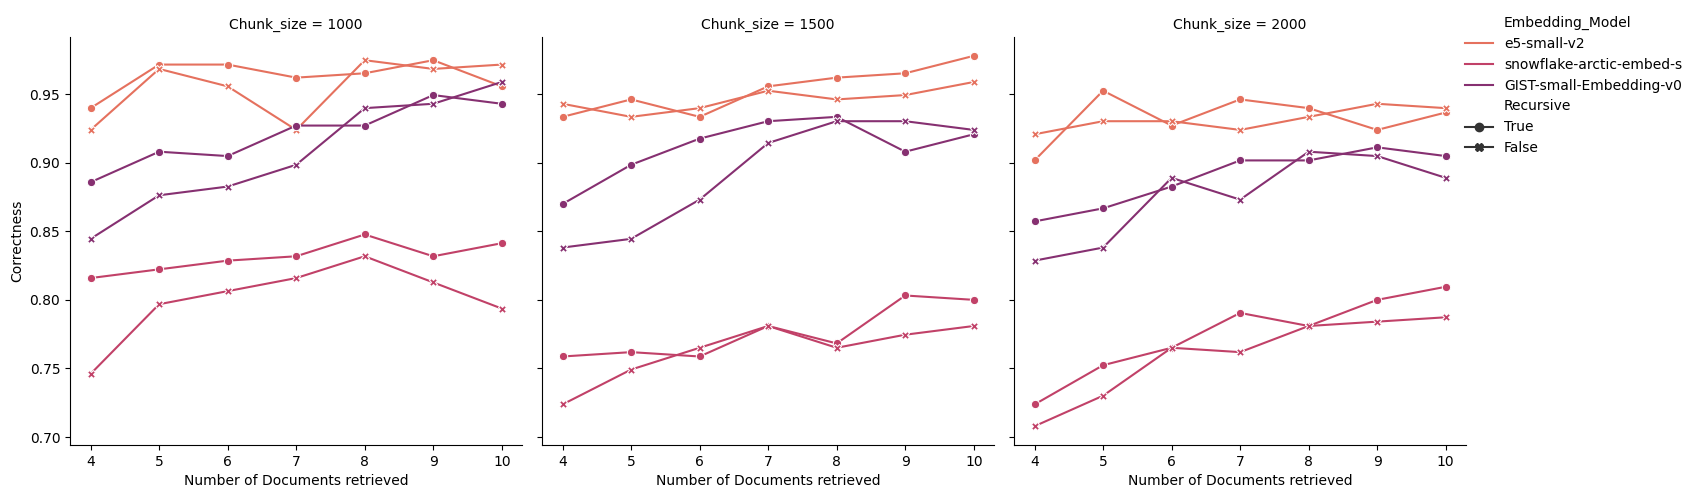

In [17]:
ax = sns.relplot(data=toplot_final, x ="NumberofDocuments", y="eval_score_gemini-2.0-flash", hue="Embedding_Model", errorbar=None, style= "Recursive", markers=True, dashes=False, palette="flare", col="Chunk_size", kind="line")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel='Number of Documents retrieved', ylabel='Correctness')